All of my effort in Titanic are contained in this Notebook. You can upvote it for encouragement if you can find some help from this Notebook.
As my purpose is to study the basic data process techniques by Titanic data set, I believe there still have many details can be dredged to improve my model, but I think it's better enough for me.<br/>
I am a student from China, and Waiting to go to NEU for my postgraduate study. I know my great distance from good English expression. So, please forgive my poor English if it has brought you extra difficulty in reading.<br/>
It's so cool that I can find so many people from all over the world. I hope my English doesn't matter you.<br/>
**Please contact me without hesitation If you have some suggestions on my Notebook or my English : ).**<br/>
Thanks for watching!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.cross_validation import KFold
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')

id_list = test_data["PassengerId"]
train_data = train_data.drop(['PassengerId'], axis=1)
test_data = test_data.drop(['PassengerId'], axis=1)

genderclassmodel.csv
gendermodel.csv
gendermodel.py
myfirstforest.py
test.csv
train.csv



/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


There are some missing values exist in columns *Age*, *Embarked* and *Cabin*.
In general, we using mode to fill *Embarked* because it has just 2 missing value, and using linear regression to predict *Age* because the age maybe a very important feature in this question.
In fact, there are some missing value in column *Fare* at test set. with respect to *Fare*, I believe use mean value is better.

In [4]:
def feature_normalization(feat_vector):
    # scala value to [-1, +1]
    max_value = max(feat_vector)
    min_value = min(feat_vector)
    mean_value = feat_vector.mean()
    return (feat_vector - mean_value) / (max_value - min_value)


# It's not reasonable to transfer *Embarked* or *Pclass* into continuous value
def dummy(data, columns):
    for column in columns:
        if column not in data.columns:
            continue
        dummy_data = pd.get_dummies(data[column], drop_first=True)
        # rename columns: column name + 1,2,3
        num = len(dummy_data.loc[1, :])
        dummy_data.columns = [column+str(x+1) for x in range(num)]
        data = pd.concat([data, dummy_data], axis=1)

        data = data.drop(column, axis=1)
    return data

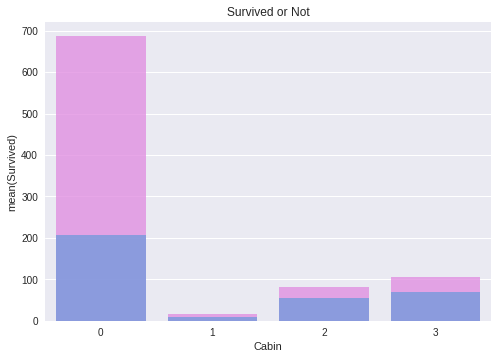

,Fare
Cabin,
0,19.157325
1,17.493135
2,49.281278
3,106.072642


In [5]:
def cabin_extract(data):
    # classify Cabin by fare
    data['Cabin'] = data['Cabin'].fillna('X')
    data['Cabin'] = data['Cabin'].apply(lambda x: str(x)[0])
    data['Cabin'] = data['Cabin'].replace(['A', 'D', 'E', 'T'], 'M')
    data['Cabin'] = data['Cabin'].replace(['B', 'C'], 'H')
    data['Cabin'] = data['Cabin'].replace(['F', 'G'], 'L')
    data['Cabin'] = data['Cabin'].map({'X': 0, 'L': 1, 'M': 2, 'H': 3}).astype(int)
    return data

train_data = cabin_extract(train_data)
test_data = cabin_extract(test_data)
# show the connection between Cabin and Survive rate
ax = plt.axes()
data = train_data.groupby(['Cabin'])[['Survived']].count()
sns.barplot(x=data.index, y=data['Survived'], alpha=0.8, color='violet', ax=ax)
data = train_data.groupby(['Cabin'])[['Survived']].sum()
sns.barplot(x=data.index, y=data['Survived'], alpha=0.8, color='cornflowerblue', ax=ax)
ax.set_title('Survived or Not')
sns.plt.show()
train_data.groupby(['Cabin'])[['Fare']].mean()  # mean fare of each cabin class

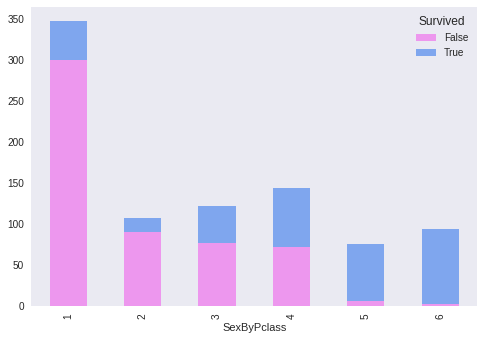

In [6]:
def SexByPclass(data):
    data['Sex'] = data['Sex'].map({'female': 1, 'male':0})
    data['Sex'] = data['Sex'].astype(int)
    data['Pclass'] = data['Pclass'].map({1: 3, 2: 2, 3:1}).astype(int)
    # data['SexByPclass'] = feature_normalization((data['SexTemp'] * data['Pclass']).astype(int))
    data.loc[data['Sex']==0, 'SexByPclass'] = data.loc[data['Sex']==0, 'Pclass']
    data.loc[data['Sex']==1, 'SexByPclass'] = data.loc[data['Sex']==1, 'Pclass'] + 3
    data['SexByPclass'] = data['SexByPclass'].astype(int)
    return data

train_data = SexByPclass(train_data)
test_data = SexByPclass(test_data)
temp = pd.crosstab([train_data.SexByPclass,], train_data.Survived.astype(bool))
temp.plot(kind='bar', stacked=True, color=['violet','cornflowerblue'], alpha=0.8, grid=False)

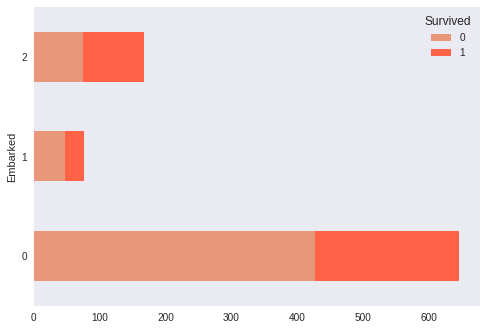

In [7]:
def fill_missing_embarked(data):
    freq_port = data['Embarked'].mode()[0]
    data['Embarked'] = data['Embarked'].fillna(freq_port)
    data['Embarked'] = data['Embarked'].map({'S': 0, 'Q': 1, 'C': 2}).astype(int)
    return data

train_data = fill_missing_embarked(train_data)
test_data = fill_missing_embarked(test_data)
temp = pd.crosstab(train_data.Embarked, train_data.Survived)
temp.plot(kind='barh', stacked=True, color=['darksalmon','tomato'], grid=False)

We can find that 'S' is the most frequent one, and the passenger from port  'C' are more likely to survive.

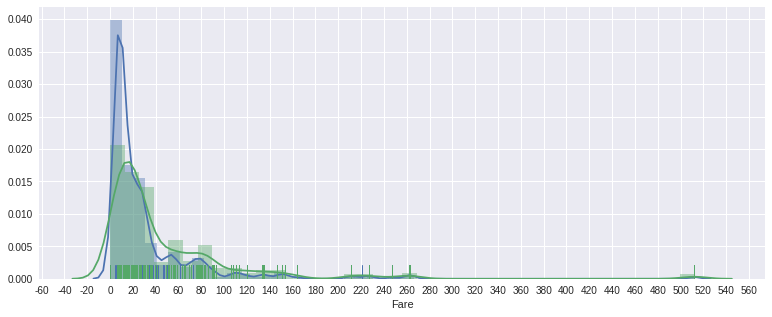

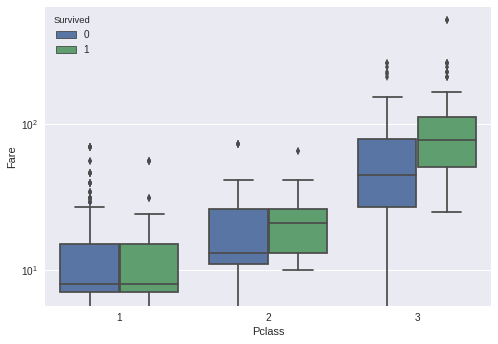

In [8]:
def fare_info(data):
    data.loc[data.Fare.isnull(), 'Fare'] = data['Fare'].mean()
    data['Fare'] = data['Fare'].astype(int)
    return data

train_data = fare_info(train_data)
test_data = fare_info(test_data)

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
xmajorLocator   = MultipleLocator(20)  # set the major locator to multiples of 5
xmajorFormatter = FormatStrFormatter('%1.0f')

sns.plt.figure(figsize=(13, 5))
ax = sns.plt.axes()
sns.distplot(train_data['Fare'], kde = True, rug = True)
sns.distplot(train_data.loc[train_data['Survived']==1, 'Fare'], kde = True, rug = True)
ax.xaxis.set_major_locator(xmajorLocator)  
ax.xaxis.set_major_formatter(xmajorFormatter) 
sns.plt.show()

ax = sns.boxplot(x="Pclass", y="Fare", hue="Survived", data=train_data);
ax.set_yscale('log')

sns.plt.show()

From the distribution, we can get, the people whose ticket *Fare* range from 0 to 20 are in low survive rate.

In [9]:
def fare_stage(data, mean_fare):
    data.loc[data['Fare'] < mean_fare[1], 'FareStage'] = 1
    data.loc[(data['Fare'] > mean_fare[1]) & (data['Fare'] < mean_fare[2]), 'FareStage'] = 2
    data.loc[(data['Fare'] > mean_fare[2]) & (data['Fare'] < mean_fare[3]), 'FareStage'] = 3
    data.loc[data['Fare'] > mean_fare[3], 'FareStage'] = 4
    return data

combine = pd.concat([train_data.drop('Survived', 1), test_data])
mean_fare = combine.groupby('Pclass')['Fare'].mean()
train_data = fare_stage(train_data, mean_fare)
test_data = fare_stage(test_data, mean_fare)

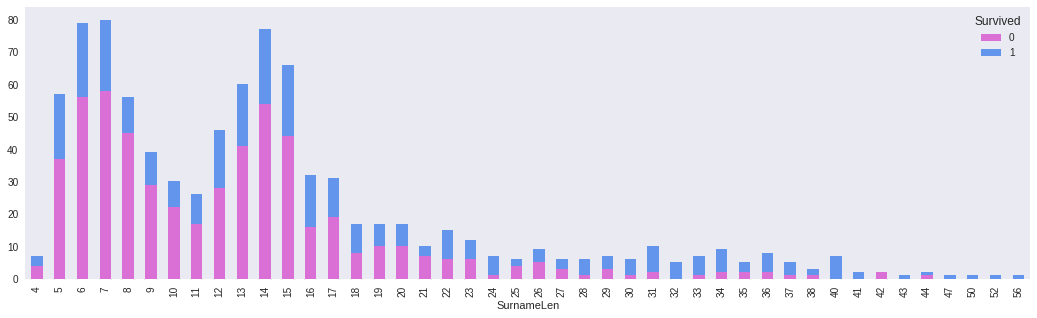

In [10]:
def name_extract(data):
    # extract Title from name
    data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)
    # delete rare title
    data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace(['Mlle', 'Ms'], 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    data['Surname'] = data['Name'].apply(lambda x: str(x).split('.')[1].split(' ')[1])
    data['Surname'] = data.Surname.str.replace('(', '')
    title_map = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    data['Title'] = data['Title'].map(title_map).astype(int)
    data['SurnameLen'] = data['Name'].apply(lambda x: len(str(x).split('.')[1])).astype(int)
                                            
    return data.drop('Name', axis=1) 



train_data = name_extract(train_data)
test_data = name_extract(test_data)

temp = pd.crosstab(train_data.SurnameLen, train_data.Survived)
temp.plot(kind='bar', stacked=True, color=['orchid','cornflowerblue'], grid=False, figsize=(18, 5))

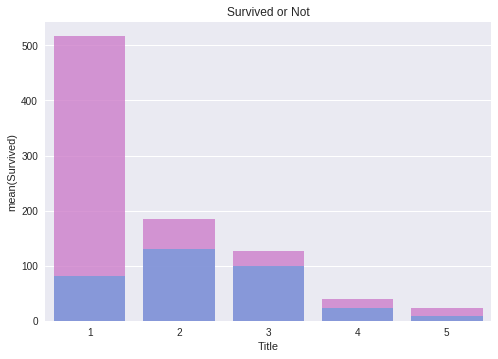

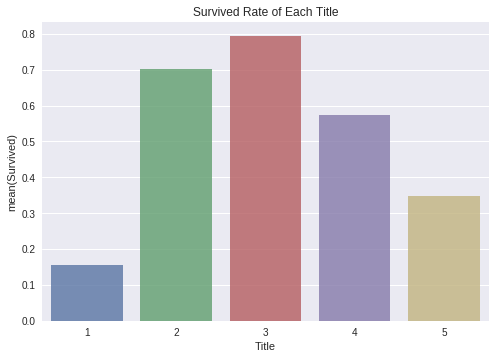

In [11]:
#sns.distplot(train_data['Title'], kde=True, rug=False)
#plt.show()
ax = plt.axes()
data = train_data.groupby(['Title'])[['Survived']].count()
sns.barplot(x=data.index, y=data['Survived'], alpha=0.8, color='orchid', ax=ax)
data = train_data.groupby(['Title'])[['Survived']].sum()
sns.barplot(x=data.index, y=data['Survived'], alpha=0.8, color='cornflowerblue', ax=ax)
ax.set_title('Survived or Not')
sns.plt.show()
ax = plt.axes()
data = train_data.groupby(['Title'])[['Survived']].mean()
sns.barplot(x=data.index, y=data['Survived'], alpha=0.8, ax=ax)
ax.set_title('Survived Rate of Each Title')
sns.plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


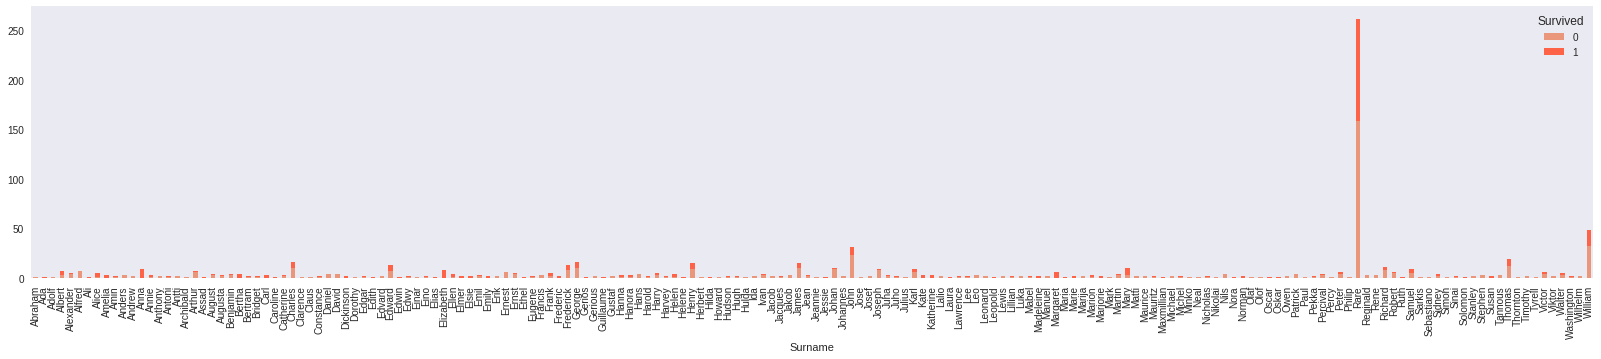

In [12]:
def surname_extract(train, test):
    Survived = train['Survived']
    combine = pd.concat([train_data.drop('Survived',1),test_data])
    combine['CommonSurname'] = np.where(combine.groupby(['Surname'])['Pclass'].transform('count') > 1, 1, 0)
    combine.loc[combine['CommonSurname']==0, 'Surname'] = 'Rare'
    train = combine.iloc[:len(train)]
    train['Survived'] = Survived
    test = combine.iloc[len(train):]
    return  train, test

train_data, test_data = surname_extract(train_data, test_data)
temp = pd.crosstab(train_data.Surname, train_data.Survived)
temp.plot(kind='bar', stacked=True, color=['darksalmon','tomato'], grid=False, figsize=(28, 5))
#I can't find the way to use Surname as its completely sporadic disturbution
train_data = train_data.drop('Surname', axis=1)
test_data = test_data.drop('Surname', axis=1)

In [13]:
def family_info(data):
    data['FamliySize'] = data['SibSp'] + data['Parch'] + 1
    data['Alone'] = data['Alone'] = (data['SibSp'] == 0) & (data['Parch'] == 0)
    data['Alone'] = data['Alone'].astype(int)
    # you should delete linear relation between family-size and sibsp and parch
    return data
    
train_data = family_info(train_data)
test_data = family_info(test_data)

In [14]:
def fill_missing_age(train_set, test_set):
    '''
    combina train and test data set,
    using linear regression to fill missing value of age in two data sets
    return: tuple constructed by train and test data set
    '''
    train_dropped = train_set[['Pclass', 'SibSp', 'Fare', 'FamliySize', 'Alone', 'Age']]
    test_dropped = test_set[['Pclass', 'SibSp', 'Fare', 'FamliySize', 'Alone', 'Age']]
    combine = pd.concat([train_dropped,test_dropped])
    # training regression model
    train = combine[combine.Age.notnull()]
    model = LinearRegression()
    model.fit(train.drop(['Age'], axis=1), train['Age'])
    
    data = combine.loc[combine.Age.isnull()]
    predict_ages = model.predict(data.drop('Age', axis=1))
    combine.loc[combine.Age.isnull(), 'Age'] = predict_ages
    combine['Age'] = combine['Age'].astype(int)
    train_set['Age'] = combine.iloc[:len(train_set)]['Age']
    test_set['Age'] = combine.iloc[len(train_set):]['Age']

    return train_set, test_set

train_data, test_data = fill_missing_age(train_data, test_data)


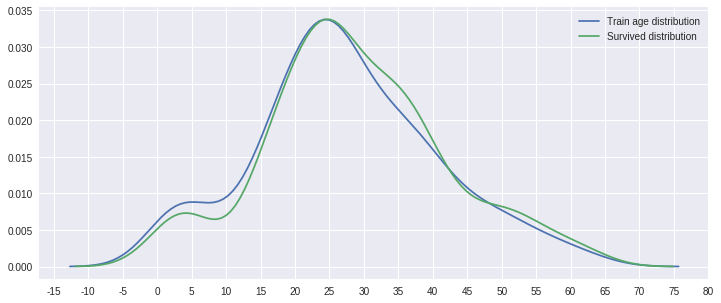

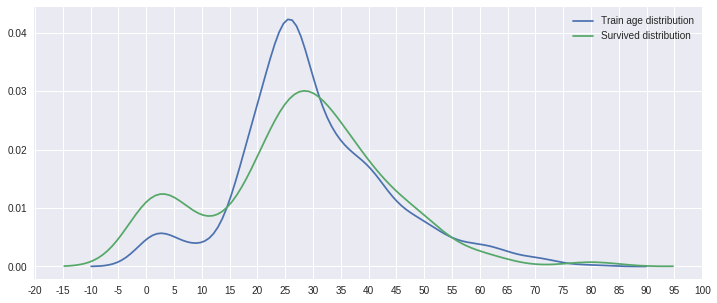

In [15]:
def age_distribution(data):
    xmajorLocator   = MultipleLocator(5)  # set the major locator to multiples of 5
    xmajorFormatter = FormatStrFormatter('%1.0f')
    sns.plt.figure(figsize=(12, 5))
    ax = sns.plt.axes()
    sns.kdeplot(data['Age'], shade=False, label='Train age distribution')
    sns.kdeplot(data.loc[data['Survived']==1, 'Age'], shade=False, label='Survived distribution')   
    ax.xaxis.set_major_locator(xmajorLocator)  
    ax.xaxis.set_major_formatter(xmajorFormatter)  
    sns.plt.show()

age_distribution(train_data.loc[train_data["Sex"]==1, :])
age_distribution(train_data.loc[train_data["Sex"]==0, :])

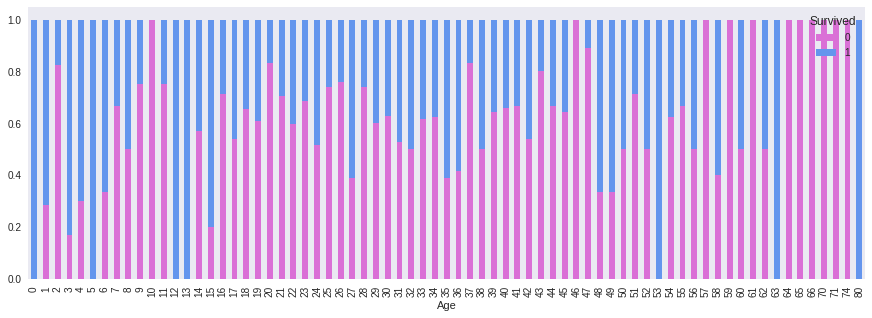

In [16]:
draw_data = pd.crosstab(train_data.Age, train_data.Survived)
draw_data.div(draw_data.sum(1).astype(float), axis=0).plot(
    kind='bar', stacked=True, color=['orchid','cornflowerblue'],grid=False, figsize=(15, 5))

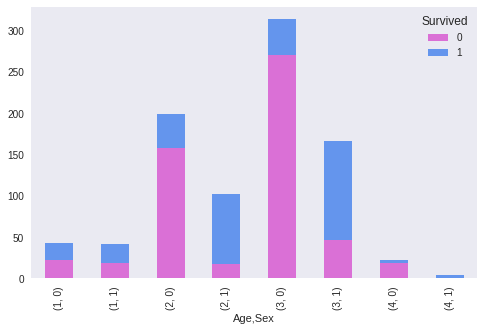

In [17]:
def age_extract(data):
    # From the upper kde plot, these two kde convex have some junctions.
    # When the green line is higher than the blue one, 
    # it indicates that the peopel whose age are in this stage have more opportunity to survive.
    data.loc[data['Age'] < 15, 'Age'] = 1
    data.loc[(data['Age'] < 32) & (data['Age'] > 14.9), 'Age'] = 3
    data.loc[(data['Age'] < 60) & (data['Age'] > 31.9), 'Age'] = 2
    data.loc[data['Age'] > 59.9, 'Age'] = 4
    data['Age'] = data['Age'].astype(int)
    return data

train_data = age_extract(train_data)
test_data = age_extract(test_data)
temp = pd.crosstab([train_data.Age, train_data.Sex], train_data.Survived)
temp.plot(kind='bar', stacked=True, color=['orchid','cornflowerblue'], grid=False, figsize=(8, 5))

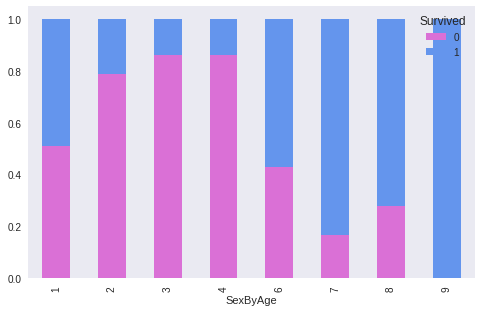

In [18]:
def SexByAge(data):
    data.loc[data['Sex']==0, 'SexByAge'] = data.loc[data['Sex']==0, 'Age']
    data.loc[data['Sex']==1, 'SexByAge'] = data.loc[data['Sex']==1, 'Age'] + 5
    data['SexByAge'] = data['SexByAge'].astype(int)
    return data


train_data = SexByAge(train_data)
test_data = SexByAge(test_data)
draw_data = pd.crosstab(train_data.SexByAge, train_data.Survived)
draw_data.div(draw_data.sum(1).astype(float), axis=0).plot(
    kind='bar', stacked=True, color=['orchid','cornflowerblue'],grid=False, figsize=(8, 5))

**Children and women go first**

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


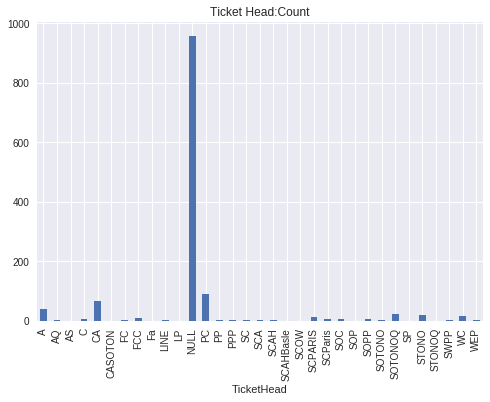

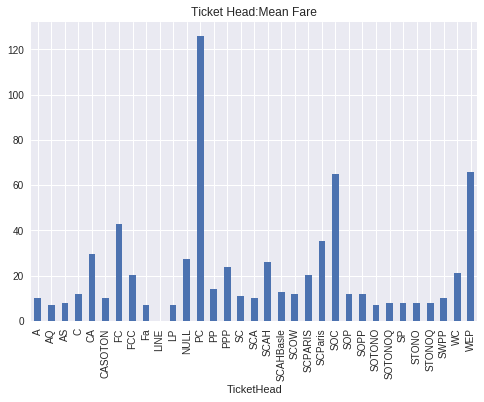

                  Fare  Survived  Count  SurviveRatio
TicketHead                                           
A            10.179487       2.0     39      0.051282
AQ            7.000000       NaN      2           NaN
AS            8.000000       0.0      1      0.000000
C            12.000000       2.0      8      0.250000
CA           29.705882      14.0     68      0.205882
CASOTON      10.000000       0.0      1      0.000000
FC           43.000000       0.0      3      0.000000
FCC          20.222222       4.0      9      0.444444
Fa            7.000000       0.0      1      0.000000
LINE          0.000000       1.0      4      0.250000
LP            7.000000       NaN      1           NaN
NULL         27.397074     254.0    957      0.265413
PC          125.826087      39.0     92      0.423913
PP           14.250000       2.0      4      0.500000
PPP          24.000000       1.0      2      0.500000
SC           11.000000       1.0      2      0.500000
SCA          10.333333      

In [19]:
def ticket_extract(train, test):
    data = pd.concat([train.drop('Survived',1),test])
    Survived = train['Survived']
    data['Ticket'] = data.Ticket.str.replace('.', '')
    data['Ticket'] = data.Ticket.str.replace('/', '')
    data['SharedTicket'] = np.where(data.groupby('Ticket')['Fare'].transform('count') > 1, 1, 0)

    data['TicketNumLen'] = data['Ticket'].apply(lambda x: len(str(x).split(' ')[-1])).astype(int)
    data['Ticket'] = data.Ticket.str.replace(' ', '')
    data['TicketHead'] = data.Ticket.str.extract('(\D*)', expand=False)
    data['TicketHead'] = data['TicketHead'].replace('', 'NULL')
    data = data.drop('Ticket', axis=1)
    train = data.iloc[:len(train)]
    train.loc[:, 'Survived'] = Survived
    test = data.iloc[len(train):]
    return  train, test



train_data, test_data = ticket_extract(train_data, test_data)

data_set = pd.concat([train_data.drop('Survived',1),test_data])
temp = data_set.groupby(['TicketHead'])[['Fare']].mean()
temp['Survived'] = train_data.groupby(['TicketHead'])[['Survived']].sum()
temp['Count'] = data_set.groupby(['TicketHead'])['Fare'].count()
temp['SurviveRatio'] = temp['Survived'] / temp['Count']

temp['Count'].plot(kind='bar', title='Ticket Head:Count')
plt.show()
temp['Fare'].plot(kind='bar', title='Ticket Head:Mean Fare')
plt.show()
print(temp)

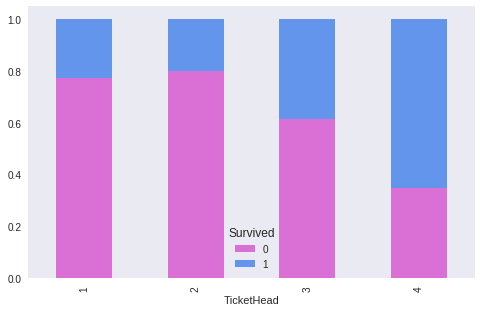

In [20]:
def transfer_ticket_head(data):
    data['TicketHead'] = data['TicketHead'].replace('PC', '4')
    data['TicketHead'] = data['TicketHead'].replace(['FC', 'WEP', 'SOC'], '2')
    data['TicketHead'] = data['TicketHead'].replace(['CA', 'FCC', 'PPP', 'SC', 'SCAH', 'SCPARIS', 'SCParis', 'WC', 'NULL'], '3')
    classes = ['A', 'AS', 'AQ','C', 'CASOTON', 'Fa', 'LINE', 'LP','PP', 'SCA', 'SCAHBasle', 'SCOW' ,'SOP', 'SOPP', 'SOTONO', 'SOTONOQ', 
               'SP', 'STONO', 'STONOQ', 'SWPP']
    data['TicketHead'] = data['TicketHead'].replace(classes, '1')
    data['TicketHead'] = data['TicketHead'].astype(int)
    return data

train_data = transfer_ticket_head(train_data)
test_data = transfer_ticket_head(test_data)
temp = pd.crosstab(train_data.TicketHead, train_data.Survived)
temp.div(temp.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['orchid','cornflowerblue'], grid=False, figsize=(8, 5))

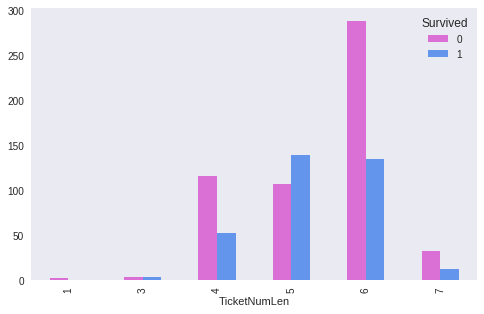

In [21]:
temp = pd.crosstab(train_data.TicketNumLen, train_data.Survived)
temp.plot(kind='bar', color=['orchid','cornflowerblue'], grid=False, figsize=(8, 5))
plt.show()

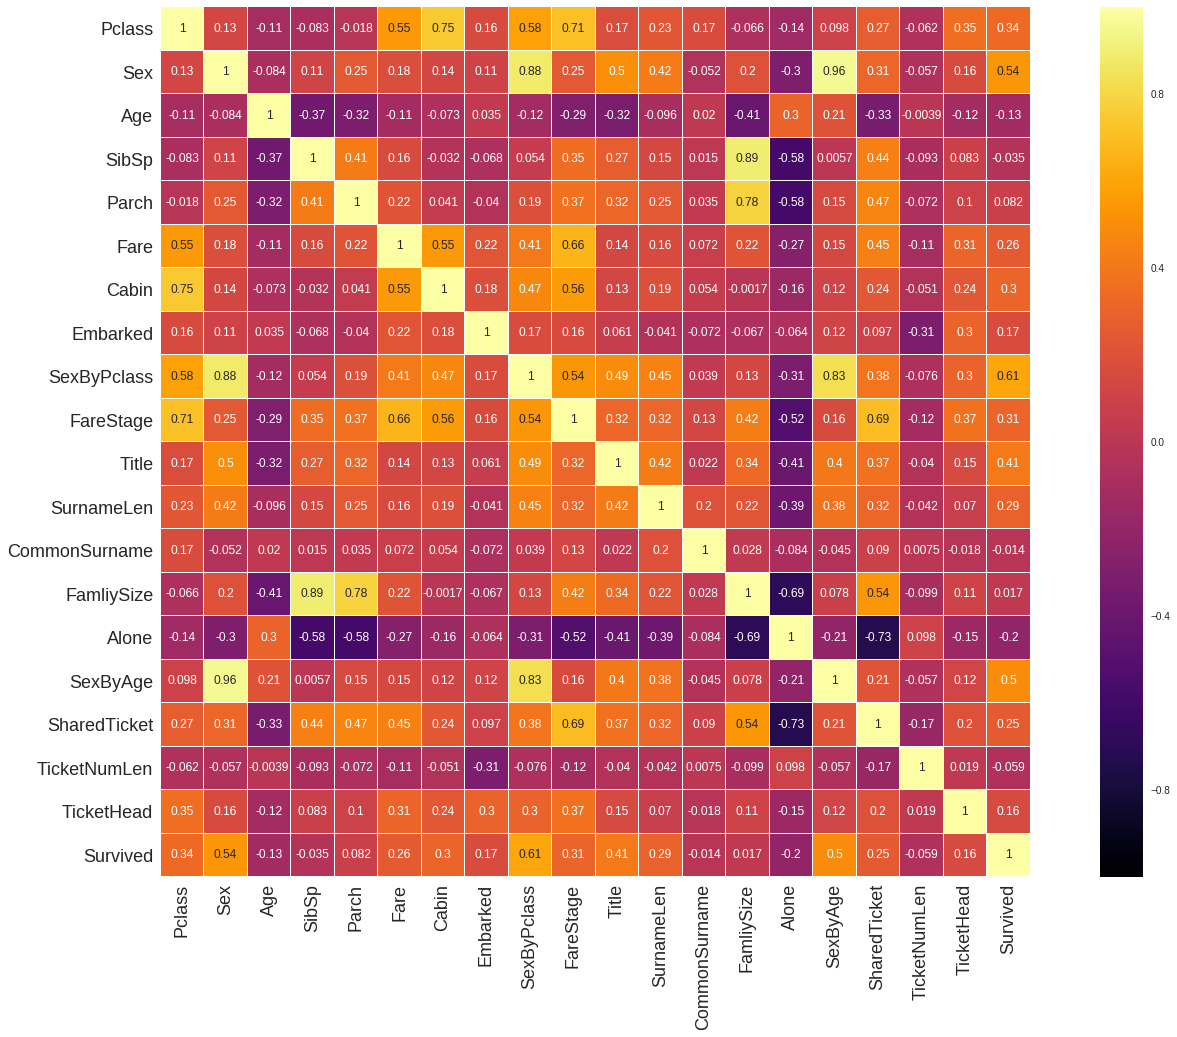

In [22]:
corr = train_data.corr()
f, ax = plt.subplots(figsize=(25,16))
sns.plt.yticks(fontsize=18)
sns.plt.xticks(fontsize=18)

sns.heatmap(corr, cmap='inferno', linewidths=0.1,vmax=1.0, square=True, annot=True)

The good correlation between *Embarked* and *Survived* makes me wonder.  I also find out some better score in column *Embarked* of heap map upper. So, may we can discover the mysterious of *Embarked* in the follow joint graph.

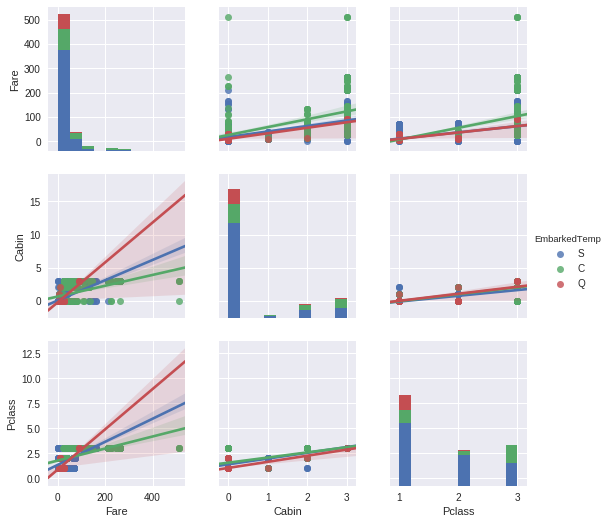

In [23]:
combine = pd.concat([train_data.drop('Survived', axis=1), test_data])
combine['EmbarkedTemp'] = combine['Embarked'].map({0: 'S', 1: 'Q', 2: 'C'})
plotVars = ['Fare', 'Cabin', 'Pclass']
sns.set()
sns.pairplot(combine, vars=plotVars, hue='EmbarkedTemp', kind='reg')
sns.plt.show()
del combine

We can find, the people from 'C' embarked port are in higher fare and better ticket class and better cabin than 'S' and 'Q'.

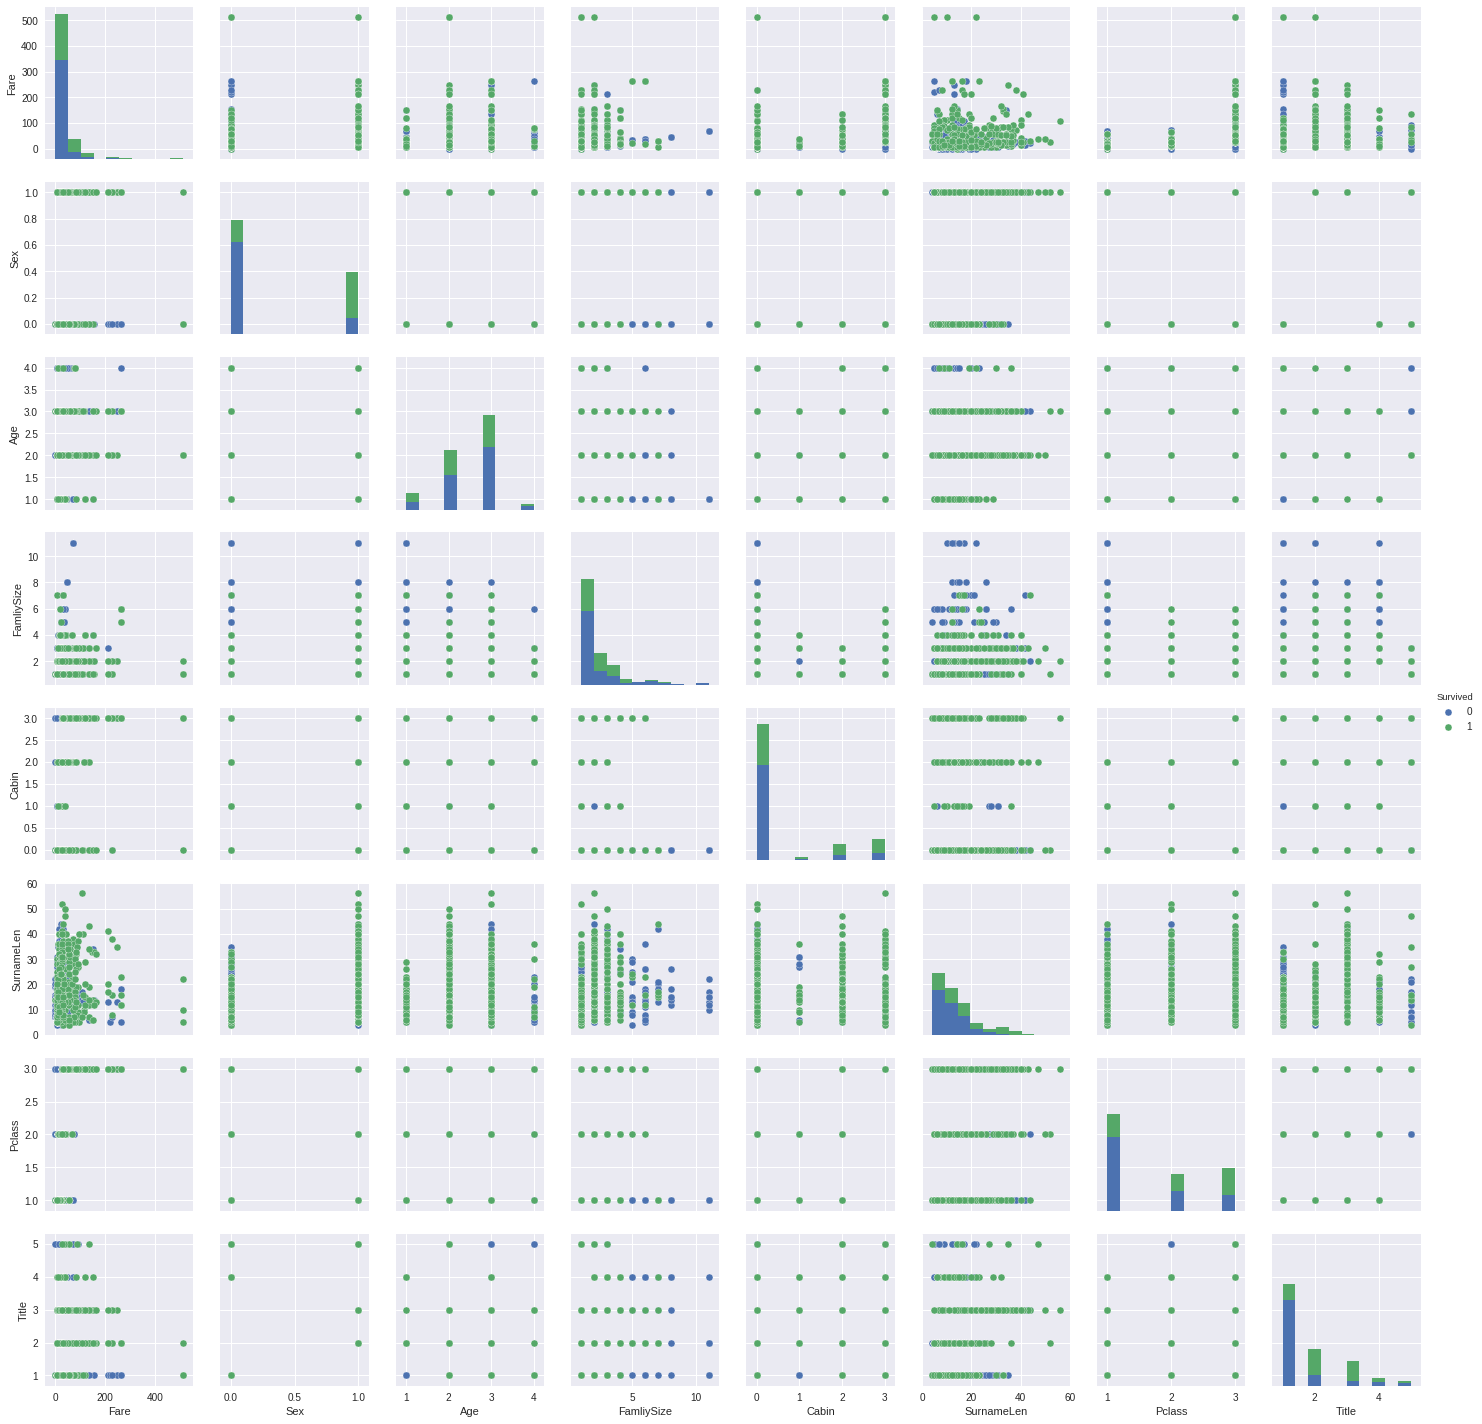

In [24]:
plotVars = ['Fare', 'Sex','Age', 'FamliySize', 'Cabin', 'SurnameLen', 'Pclass', 'Title']
sns.set()
sns.pairplot(train_data, vars=plotVars, hue='Survived')
sns.plt.show()

In [25]:
# Embarked should be transformed to one-hot variable
train_data = dummy(train_data, ['Embarked'])
test_data = dummy(test_data, ['Embarked'])

In [26]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 21 columns):
Pclass           891 non-null int64
Sex              891 non-null int64
Age              891 non-null int64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null int64
Cabin            891 non-null int64
SexByPclass      891 non-null int64
FareStage        891 non-null float64
Title            891 non-null int64
SurnameLen       891 non-null int64
CommonSurname    891 non-null int64
FamliySize       891 non-null int64
Alone            891 non-null int64
SexByAge         891 non-null int64
SharedTicket     891 non-null int64
TicketNumLen     891 non-null int64
TicketHead       891 non-null int64
Survived         891 non-null int64
Embarked1        891 non-null uint8
Embarked2        891 non-null uint8
dtypes: float64(1), int64(18), uint8(2)
memory usage: 181.0 KB


##Random Forest<br/>
In my codes, the RF will be the most important classifier in voting

In [27]:
# search for the best parameters of random forest
def parameter_evaluate(data):
    clf_ev = RandomForestClassifier()
    x, y = data.drop(['Survived'], axis=1), data['Survived']
    parameters = {'n_estimators': [100, 300], 'max_features': [3, 4, 5, 'auto'],
                  'min_samples_leaf': [9, 10, 12], 'random_state': [7]}
    grid_search = GridSearchCV(estimator=clf_ev, param_grid=parameters, cv=10, scoring='accuracy')
    print("parameters:")
    # train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
    grid_search.fit(x, y)
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    bsp = grid_search.best_estimator_.get_params()  # the dict of parameters with best score
    for param_name in sorted(bsp.keys()):
        print("\t%s: %r" % (param_name, bsp[param_name]))
    return bsp

parameters = parameter_evaluate(train_data)  
# we don't need to search everytime after getting best parameters
# if we haven't change anything, we can use the following parameters to accelebrate our code
# parameters = {'n_estimators': 100, 'max_features': 5, 'min_samples_leaf': 10, 'random_state': 7}
rf = RandomForestClassifier(**parameters)
rf.fit(train_data.drop(['Survived'], axis=1), train_data['Survived'])

parameters:
Best score: 0.827
Best parameters set:
	bootstrap: True
	class_weight: None
	criterion: 'gini'
	max_depth: None
	max_features: 3
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_impurity_split: None
	min_samples_leaf: 9
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	n_estimators: 300
	n_jobs: 1
	oob_score: False
	random_state: 7
	verbose: 0
	warm_start: False


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

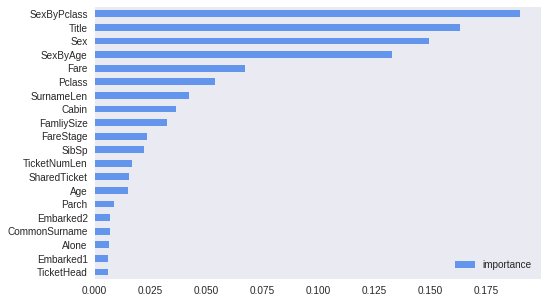

In [28]:
names = train_data.drop(['Survived'], axis=1).columns
ratios = rf.feature_importances_

feature_important = pd.DataFrame(index=names, data=ratios, columns=['importance'])
feature_important = feature_important.sort_values(by=['importance'], ascending=True)
feature_important.plot(kind='barh', stacked=True, color=['cornflowerblue'], grid=False, figsize=(8, 5))

Then, I would like to delete some features which will make a bad influence on model. The Basis that I delete these features are **the feature importance** and **the heat map between features** Above. <br/>
Moreover, if there is a linear relation between feature A and B, remove A or B even it's much important. Just as *SexByAge* and *SexByAgeByPclass*, I got a higher score after removing *SexByAge*. 

##Logistic Regression
Because I need to keep the accuracy of RF, so I decide to bypass the process feature scaling.

In [29]:
lr = LogisticRegression(random_state=7)
lr.fit(train_data.drop(['Survived'], axis=1), train_data['Survived'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=7, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

##Feature Selection  
###Ablative analysis<br/>
After the above feature extractions and analysis, we should select the useful features to complete our work. 
While the feature number have influence on Random Forest's predict, we use Decision Tree to do this feature selection.

In [30]:
def k_fold_to_get_acc(clf, x_split, y_split):
    kf = KFold(len(y_split), n_folds=10)
    acc_t = 0
    acc_v = 0
    for train, valid in kf:
        x_train, y_train = x_split.iloc[train], y_split.iloc[train]
        x_valid, y_valid = x_split.iloc[valid], y_split.iloc[valid]
        
        clf = clf.fit(x_train, y_train)
        pred = clf.predict(x_train)
        acc_t += np.mean(pred==y_train)  # accuracy on train
        pred = clf.predict(x_valid)
        acc_v += np.mean(pred==y_valid)  # accuracy on validation
    return acc_t * 10, acc_v * 10


def ablative_analysis(clf, train, feats):
    x, y = train.drop('Survived', 1), train["Survived"]
    acc = {}
    dropped = []
    print('all reserved - %%%.2f  %%%.2f' % k_fold_to_get_acc(clf, x, y))
    while(len(feats) > 0):
        item = feats[0]
        feats = feats[1:]
        dropped.append(item)
        acc[item] = k_fold_to_get_acc(clf, x.drop(dropped, 1), y)
    for key in acc:
        acc_t, acc_v = acc[key]
        print('del %s -> %%%.2f  %%%.2f' % (key, acc_t, acc_v))
    print('Remains:')
    print(list(x.drop(dropped, 1).columns))
    
features = list(feature_important.index)[:-6]
dtc = DecisionTreeClassifier(criterion='gini', random_state=7)
ablative_analysis(dtc, train_data, features)

all reserved - %98.38  %76.77
del TicketHead -> %98.25  %77.89
del Embarked1 -> %98.10  %77.89
del Alone -> %98.10  %77.56
del CommonSurname -> %97.66  %77.11
del Embarked2 -> %97.44  %77.79
del Parch -> %97.44  %77.45
del Age -> %97.44  %77.67
del SharedTicket -> %97.44  %77.56
del TicketNumLen -> %96.20  %77.11
del SibSp -> %96.20  %77.56
del FareStage -> %96.20  %76.89
del FamliySize -> %95.59  %76.67
del Cabin -> %95.37  %77.23
del SurnameLen -> %90.56  %81.38
Remains:
['Pclass', 'Sex', 'Fare', 'SexByPclass', 'Title', 'SexByAge']


We can find, keep all features we extract will lead to overfitting.<br/>
There were some superfluous feature in our model. <br/>
We should delete the features *Parch* and *SibSp*because they have linear relation with other features.<br/>
And delete *TicketHead* and *SurnameLen* because of its lower importance.
Besides, the features I used finally, were tested by submiting. As a freshman to Machine Learning, I haven't formed my own way to select features effectively.<br/>
I will keep on studying to refresh this notebook! If you have better method on feature selection, please let me know,I'd appreciate it very much!

##K Neighbors

In [31]:
knn = KNeighborsClassifier()
knn.fit(train_data.drop(['Survived'], axis=1), train_data['Survived'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

##Ensemble RF, LR, KNN by voting

In [32]:
eclf1 = VotingClassifier(estimators=[
        ('lr', lr), ('rf', rf), ('knn', knn)], voting='soft', weights=[1, 2, 1])
eclf1 = eclf1.fit(train_data.drop(['Survived'], axis=1), train_data['Survived'])
results = eclf1.predict(test_data)
output = pd.DataFrame({'PassengerId': id_list, "Survived": results})
output.to_csv('prediction.csv', index=False)